For clarity I would prefer setting up the environment specifically with the same efforts as I did to avoid any possibility of numerical or functional differences. This is a windows machine with an nvidia graphics driver set up with tensorflow using CUDA and cuDNN to utilize the GPU to make calculations more efficient. The environment created needs to be set up from scratch, it has no pandas, no numpy, no sklearn libraries. Below are the guides i followed in setting up my environment. I used the first guide and had the second as support incase i needed clarity.

These are the guides used to set up the tensorflow environment: 

    https://saturncloud.io/blog/how-to-run-jupyter-notebook-on-gpus/
    https://www.xda-developers.com/use-gpu-jupyter-notebook/

You will need to install the CUDA driver, cuDNN library and possibly update NVidia drivers

before entering the jupyter notebook, in the anaconda terminal copy and paste:

    pip install pandas numpy tensorflow_hub keras_tuner matplotlib seaborn scikit-learn imbalanced-learn

Now navigate to the directory housing the TensorFlowProject.ipynb, and place the credit card client default .csv in there.

Link to the data set: https://www.kaggle.com/datasets/mariosfish/default-of-credit-card-clients

Now every cell should run correctly. If the Neural networks printing every line out is annoying, just cntrl+f search for 'verbose' and set them equal to 0 to silence their outputs.


# Project goals and Objective

**Milestone 1: ZACHARY GONZALEZ CS-482-101**

In this Project we will:
    Obtain a higher accuracy then previous works, use a new Data Mining technique than anyone else, and address questions not previously answered; By using tensor flow with hyper paramater tuning, scaling minority class, applying weights, addressing issues within the data-set, and viewing the data through different methods than others have attempted.
    
**Submission**: One file, either PDF or ipynb

**Task Overview:**

    1.) load, clean, and verify data
    2.) Distribution graphs, minority group identification, correlation matrix, and feature importance
    3.) Address class-imbalance of target variable
    4.) Machine learning implementations w/ optimization & comparison, and metrics
    5.) Identify majority groups in target variable, devise rules for metrics, find useful info and make it easy to understand

Goals for "Success" :
- Predict if a client will pay the next month [x]
- Identify majority group within dpnm classes [x]
- Identify something that can be done to reduce dpnm [x] (Discussed during presentation not included in this report)
- identify neat data (married women and men with different dpnm metrics?) []

# Imports & TensorFlow Verification

In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV,cross_val_score,train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.compat.v1 import GraphDef
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.metrics import AUC,Accuracy
from tensorflow.keras.optimizers import Adam, SGD

from imblearn.over_sampling import RandomOverSampler

BATCH_SIZE = 1024 # This allows our model to see more data before modifying its weight values.
RAND_SEED = 42 # Reproducability for all randomseeds

In [3]:
### TensorFlow ###
print("TF version: ", tf.__version__)
# Check for GPU availability
print("GPU", "available (YES)" if tf.config.list_physical_devices("GPU") else "not available")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TF version:  2.10.0
GPU available (YES)
Num GPUs Available:  1


# Pre-Processing

In [4]:
# Check if Dtype's are usable, irrelevant features to be removed, and if all data entry counts are the same
# Categorical data already encoded
df=pd.read_csv("default of credit card clients.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   ID         30000 non-null  int64
 1   LIMIT_BAL  30000 non-null  int64
 2   SEX        30000 non-null  int64
 3   EDUCATION  30000 non-null  int64
 4   MARRIAGE   30000 non-null  int64
 5   AGE        30000 non-null  int64
 6   PAY_1      30000 non-null  int64
 7   PAY_2      30000 non-null  int64
 8   PAY_3      30000 non-null  int64
 9   PAY_4      30000 non-null  int64
 10  PAY_5      30000 non-null  int64
 11  PAY_6      30000 non-null  int64
 12  BILL_AMT1  30000 non-null  int64
 13  BILL_AMT2  30000 non-null  int64
 14  BILL_AMT3  30000 non-null  int64
 15  BILL_AMT4  30000 non-null  int64
 16  BILL_AMT5  30000 non-null  int64
 17  BILL_AMT6  30000 non-null  int64
 18  PAY_AMT1   30000 non-null  int64
 19  PAY_AMT2   30000 non-null  int64
 20  PAY_AMT3   30000 non-null  int64
 21  PAY_AMT4   3

In [5]:
df=df.drop(columns=['ID'])
# Check for nulls and duplicate entries, then drop them
print("Null values count per column: \n",df.isnull().sum(), '\n')
print("Number of duplicate rows:", df.duplicated().sum(), '\n')

df = df.dropna()
df = df.drop_duplicates()

# ERROR IN THE DATASET that the SCIENCE DIRECT and everyone else missed, marriage case of 0 shouldn't exist/is unidentified
# And education has labels 0,5, and 6 that are unidentified and invalid as we dont know what they represent
df = df[df['MARRIAGE'].isin([1,2,3])]
df = df[df['EDUCATION'].isin([1, 2, 3, 4])]

df.info()

Null values count per column: 
 LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dpnm         0
dtype: int64 

Number of duplicate rows: 35 

<class 'pandas.core.frame.DataFrame'>
Index: 29566 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  29566 non-null  int64
 1   SEX        29566 non-null  int64
 2   EDUCATION  29566 non-null  int64
 3   MARRIAGE   29566 non-null  int64
 4   AGE        29566 non-null  int64
 5   PAY_1      29566 non-null  int64
 6   PAY_2      29566 non-null  int64
 7   PAY_3      29566 non-null  int64
 8   PAY_4      29566 non-null  int64
 9   PAY_5      29566 non-null  int64
 1

# Exploratory Data Analysis

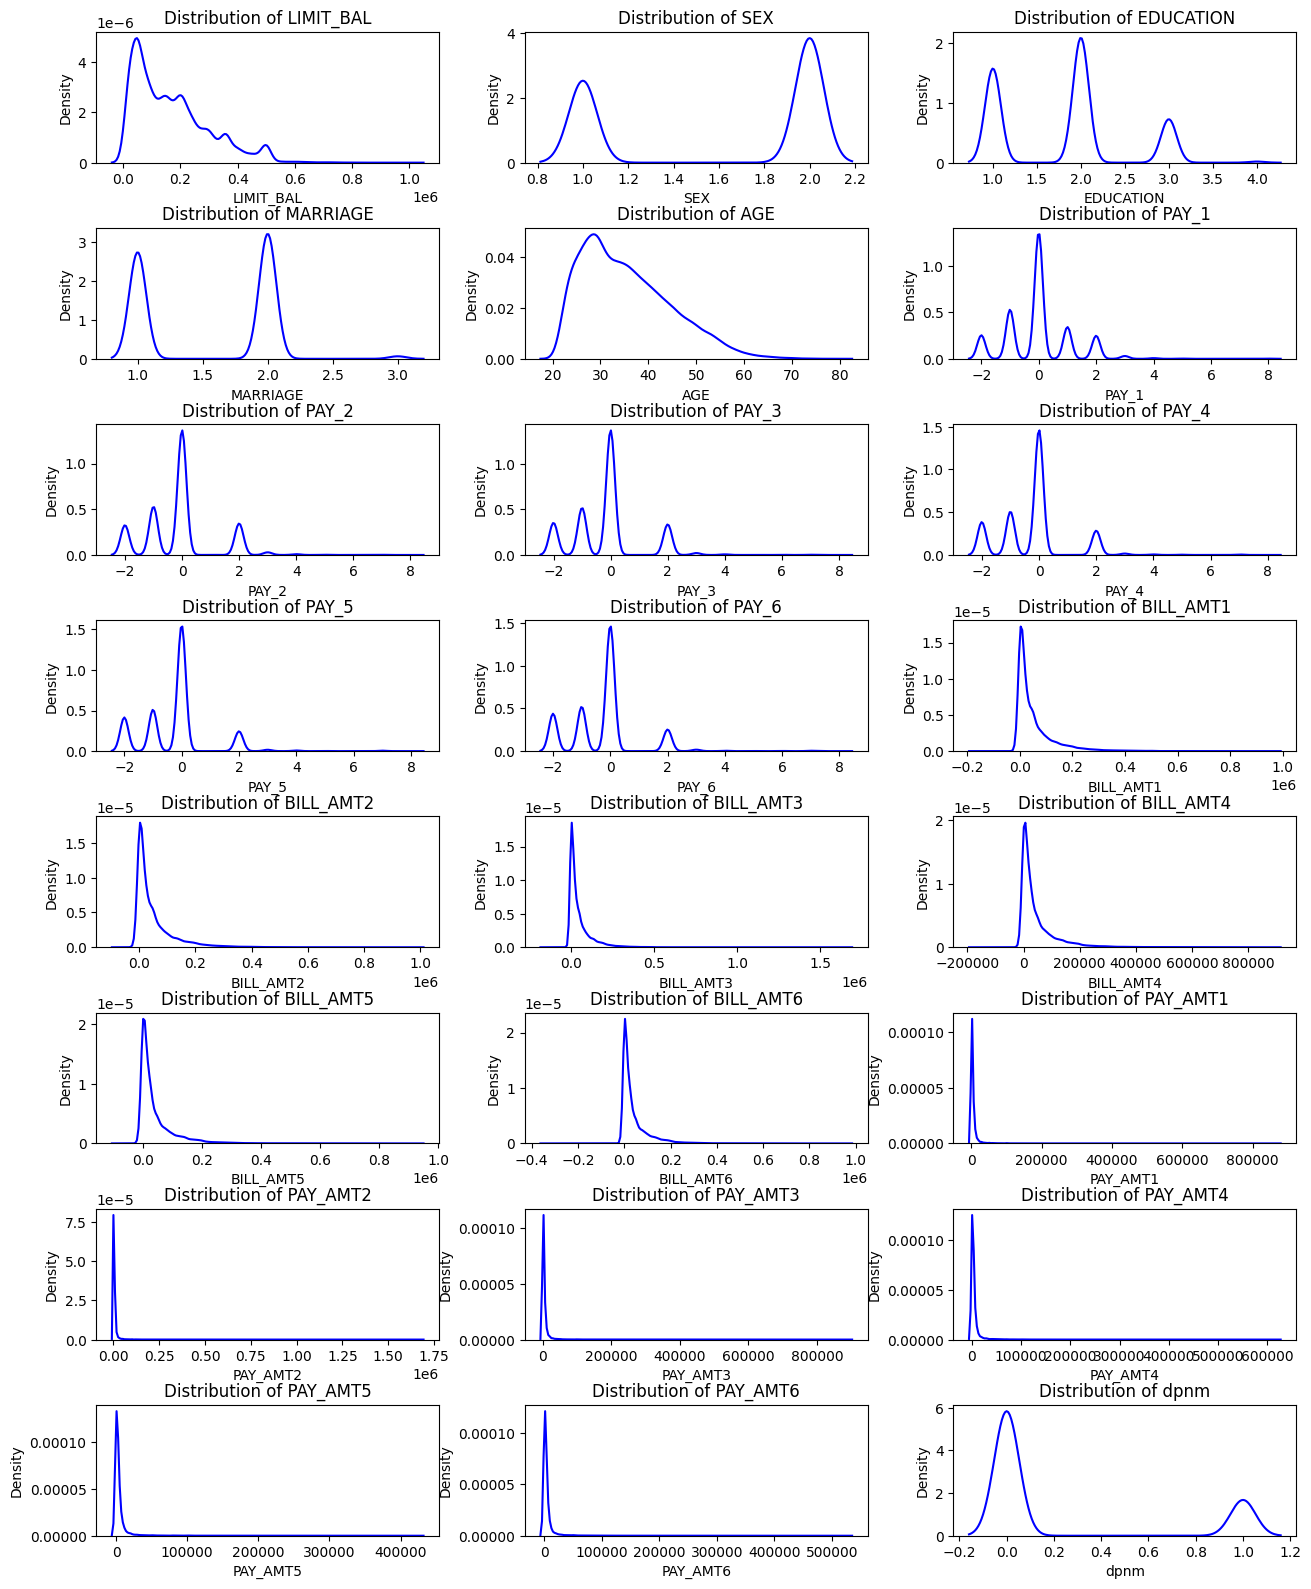

In [6]:
# DISTRIBUTION 
fig = plt.figure(figsize=(15, 20))

count = 0

all_features = df.select_dtypes(include=['float64', 'int64']).columns

for col in all_features:
    ax = fig.add_subplot(len(all_features)//3 + 1, 3, count + 1)
    
    sns.kdeplot(x=df[col], ax=ax,label='Original Data',color='blue')    

    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Density')
    count += 1

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.95, wspace=0.25, hspace=0.5)
plt.show()

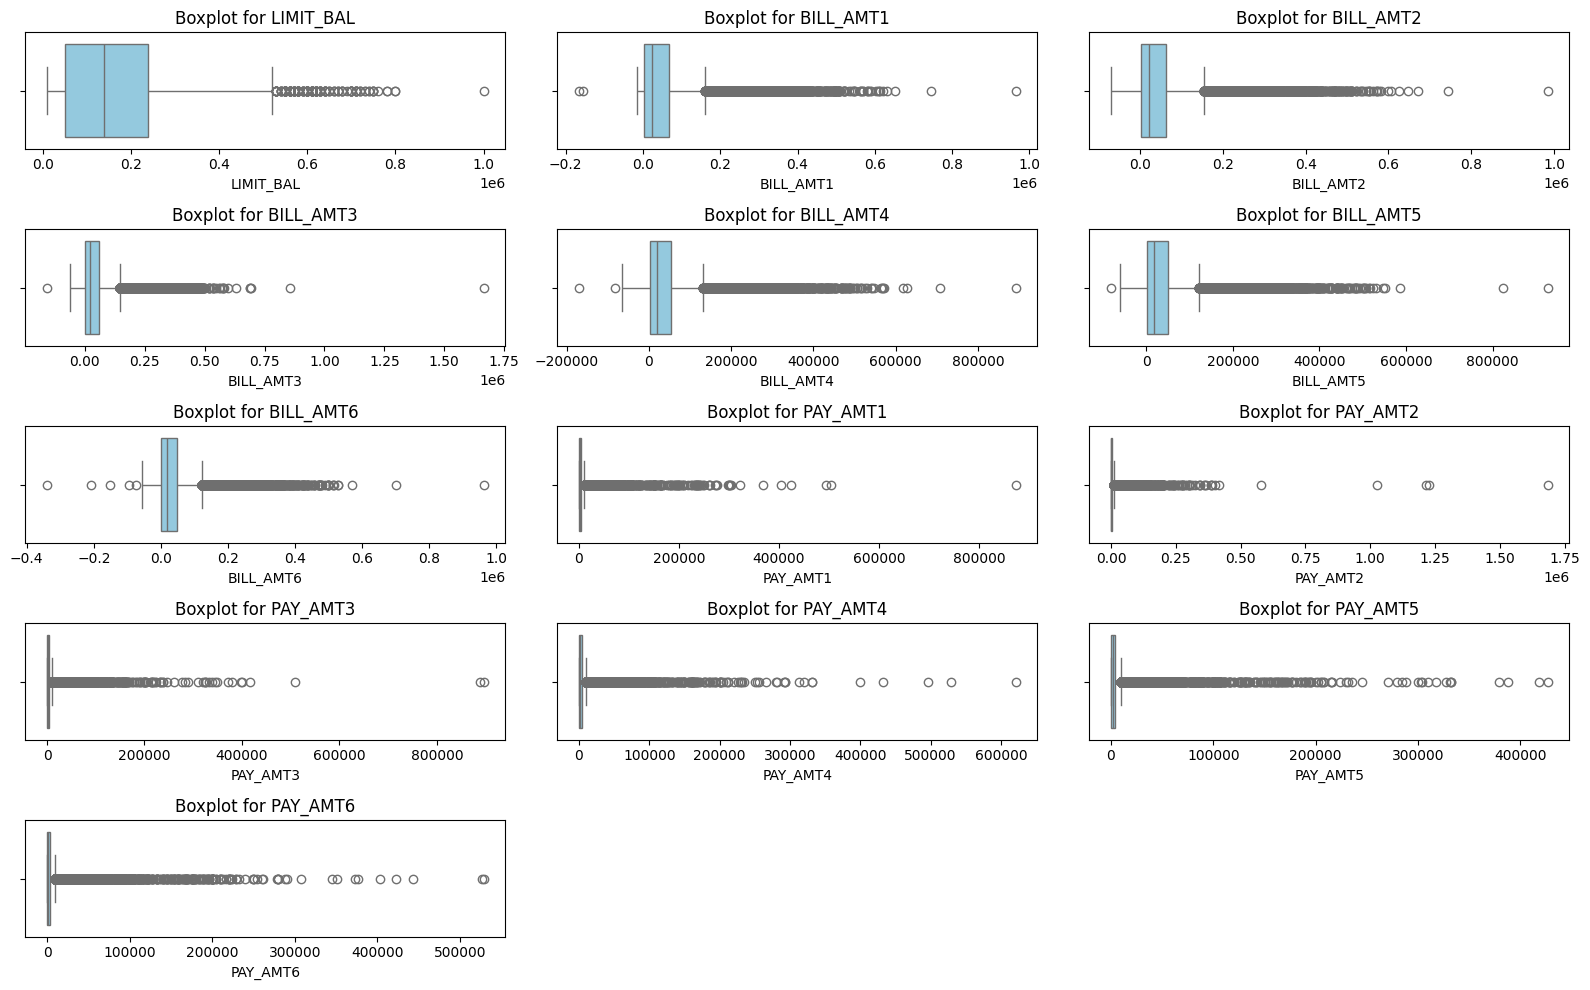

In [7]:
# Detect outliers
numerical_features = [col for col in df.columns if 'BILL_AMT' in col or 'PAY_AMT' in col or 'LIMIT_BAL' in col]
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot((len(numerical_features) // 3) + 1, 3, i)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Boxplot for {feature}')
    plt.tight_layout()

plt.show()

eyeballing it having a threshold for LIMIT_BAL greater than 600,000, BILL_AMT greater than 800,000 , and PAY_AMT greater than 500,000 would cut of the largest outliers while not removing about half of our data. 

In [8]:
pay_features = [col for col in df.columns if 'PAY_AMT' in col]
limit_features = [col for col in df.columns if 'LIMIT_BAL' in col]
bill_features = [col for col in df.columns if 'BILL_AMT' in col]

pay_threshold = 500000
limit_threshold = 800000
bill_threshold = 800000

# Filter rows based on thresholds
df = df[
    (df[pay_features] <= pay_threshold).all(axis=1) &  
    (df[limit_features] <= limit_threshold).all(axis=1) & 
    (df[bill_features] <= bill_threshold).all(axis=1)  
]

df.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,dpnm
count,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,...,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000,29554.000000
mean,167373.745686,1.603201,1.816099,1.555492,35.465758,-0.014888,-0.129187,-0.161535,-0.216451,-0.262232,...,43078.773432,40170.091967,38799.195676,5588.775259,5691.539013,5110.169757,4789.963051,4780.021452,5142.094539,0.223252
std,129741.437552,0.489242,0.710377,0.518056,9.216026,1.124104,1.198793,1.198794,1.171319,1.135280,...,63857.406603,60175.898054,59069.299663,15255.600428,16990.557635,15665.449755,14988.751915,15079.549234,17115.705120,0.416433
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1800.500000,1297.250000,1000.000000,833.500000,390.000000,300.000000,264.000000,148.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19033.000000,18107.500000,17142.500000,2100.000000,2008.000000,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54278.750000,50086.250000,49141.500000,5005.000000,5000.000000,4500.000000,4016.000000,4049.750000,4000.000000,0.000000
max,800000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,706864.000000,587067.000000,699944.000000,423903.000000,415552.000000,417588.000000,497000.000000,426529.000000,443001.000000,1.000000


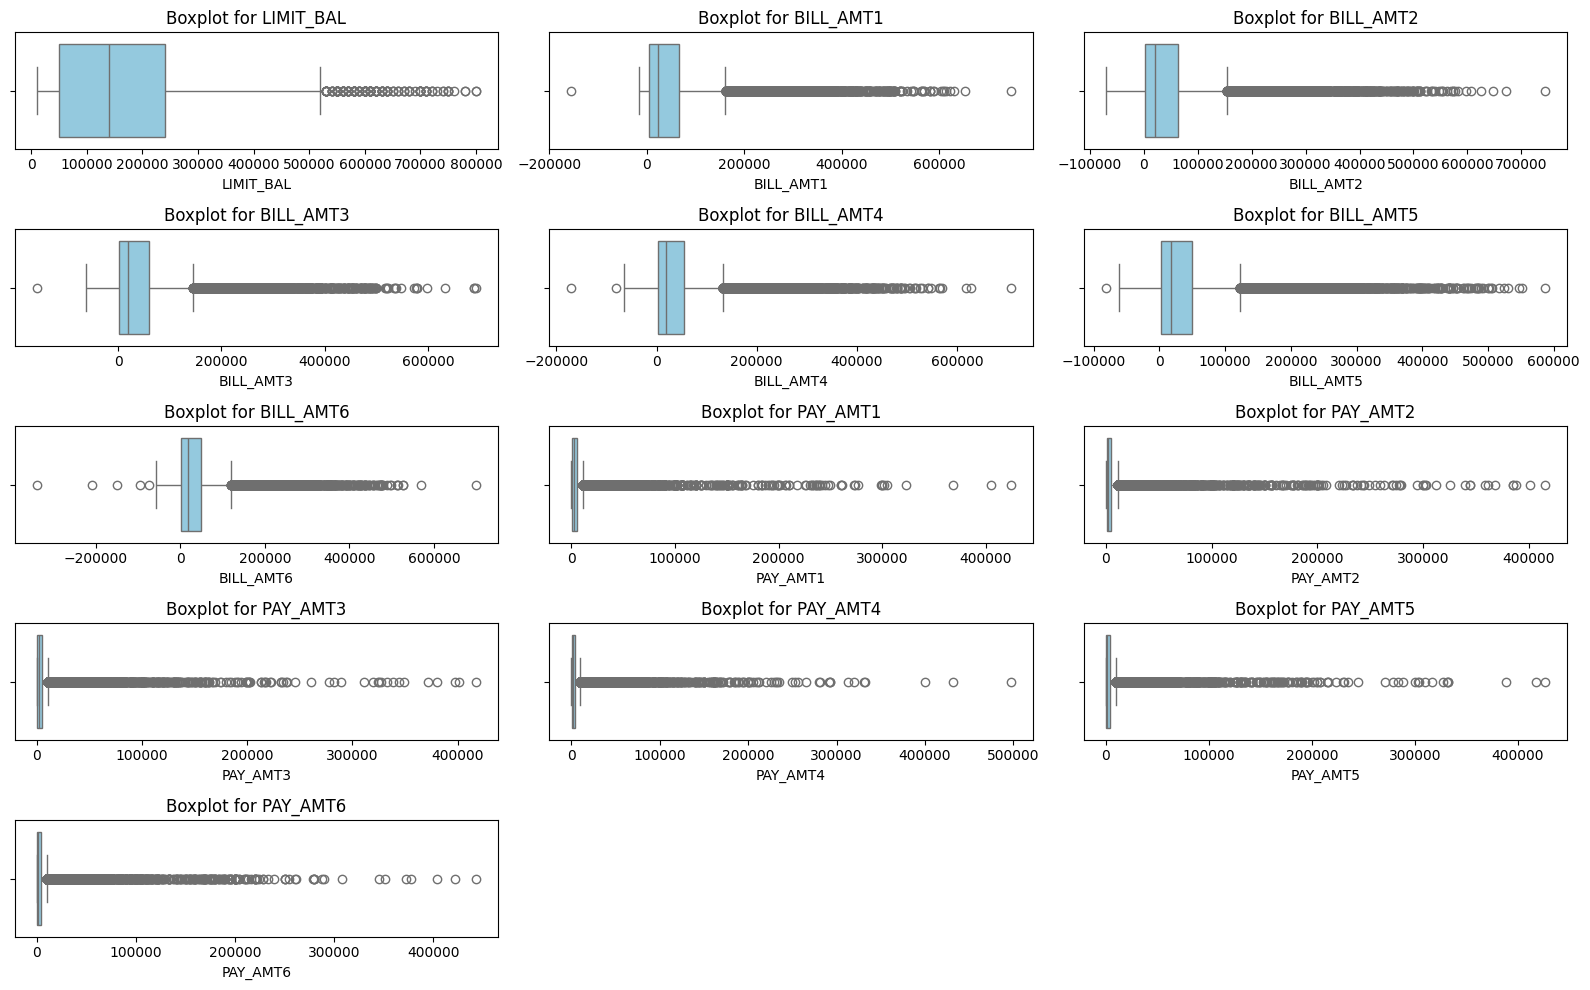

In [9]:
# Detect outliers
numerical_features = [col for col in df.columns if 'BILL_AMT' in col or 'PAY_AMT' in col or 'LIMIT_BAL' in col]
plt.figure(figsize=(16, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot((len(numerical_features) // 3) + 1, 3, i)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Boxplot for {feature}')
    plt.tight_layout()

plt.show()

Counts of dpnm classes:  dpnm
0    22956
1     6598
Name: count, dtype: int64


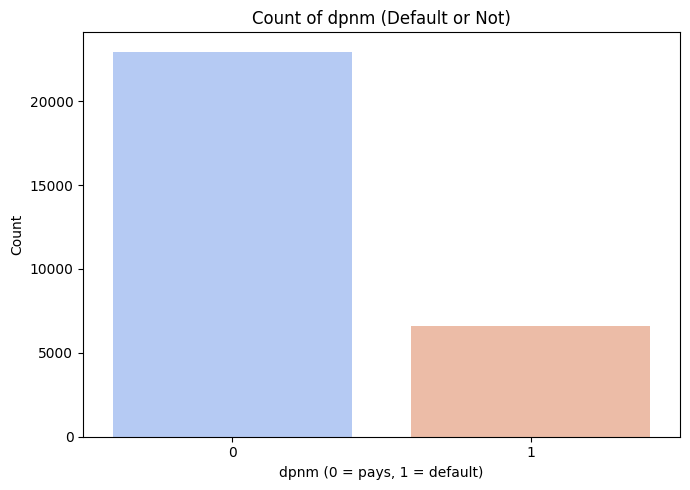

In [10]:
# Plot the count of dpnm
dpnm_counts = df['dpnm'].value_counts()
print("Counts of dpnm classes: ", dpnm_counts)
plt.figure(figsize=(7, 5))
sns.countplot(x='dpnm', data=df, palette='coolwarm', hue='dpnm',legend=False)
plt.title('Count of dpnm (Default or Not)')
plt.xlabel('dpnm (0 = pays, 1 = default)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Our class label is horribly imbalanced, upsampling can provide more insight on where the class 1 labels exist within for our distribution graphs.

According to science direct (which has done a report on the dataset), Taiwan had a 20% population below the poverty line in 2005, which correlates to our roughly 20% dpnm class label for 2006 which is when the prediction results is desired. The research was also done because the final quarter was expected to have a higher amount of dpnm, which give our dpnm class is greater than the population of those in poverty for the previous year, would be a correct assessment.

## Upscaling

In [11]:
### EXPANSION of minority group ###
# I am doing it this way because i do not want too many duplicates of the same data and i want more control over it, 
# So i will double the class 1 label and then use weights to equalize the rest.
class_1_df = df[df['dpnm'] == 1]

duplicated_class_1_df = pd.concat([class_1_df] * 2, ignore_index=True)
df = pd.concat([df, duplicated_class_1_df], ignore_index=True)
df = df.sample(frac=1, random_state=RAND_SEED).reset_index(drop=True) # Doing this to shuffle it all together so 30,000 to 40,000 arent all class 1 labels

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42750 entries, 0 to 42749
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  42750 non-null  int64
 1   SEX        42750 non-null  int64
 2   EDUCATION  42750 non-null  int64
 3   MARRIAGE   42750 non-null  int64
 4   AGE        42750 non-null  int64
 5   PAY_1      42750 non-null  int64
 6   PAY_2      42750 non-null  int64
 7   PAY_3      42750 non-null  int64
 8   PAY_4      42750 non-null  int64
 9   PAY_5      42750 non-null  int64
 10  PAY_6      42750 non-null  int64
 11  BILL_AMT1  42750 non-null  int64
 12  BILL_AMT2  42750 non-null  int64
 13  BILL_AMT3  42750 non-null  int64
 14  BILL_AMT4  42750 non-null  int64
 15  BILL_AMT5  42750 non-null  int64
 16  BILL_AMT6  42750 non-null  int64
 17  PAY_AMT1   42750 non-null  int64
 18  PAY_AMT2   42750 non-null  int64
 19  PAY_AMT3   42750 non-null  int64
 20  PAY_AMT4   42750 non-null  int64
 21  PAY_AMT5   4

Counts of dpnm classes:  dpnm
0    22956
1    19794
Name: count, dtype: int64


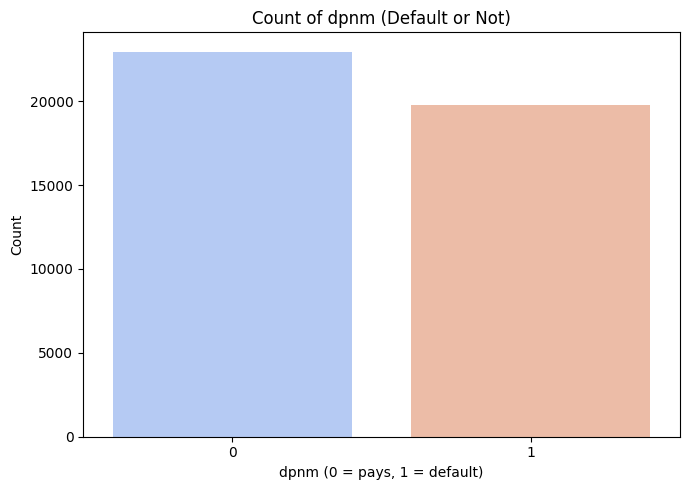

In [12]:
# Plot the count of dpnm
dpnm_counts = df['dpnm'].value_counts()
print("Counts of dpnm classes: ", dpnm_counts)
plt.figure(figsize=(7, 5))
sns.countplot(x='dpnm', data=df, palette='coolwarm', hue='dpnm',legend=False)
plt.title('Count of dpnm (Default or Not)')
plt.xlabel('dpnm (0 = pays, 1 = default)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [13]:
# Using the non-upscaled data, lets split the class label for some later research
class_0_data = df[df['dpnm'] == 0]
class_1_data = df[df['dpnm'] == 1]

Education class 4 and marriage class 3 are essentially non-existent.

Some areas after being upscaled have become dominated by the class 1 label (Doesnt Pay Next month) specifically the Pay_ feastures on delinquency of 2 months. which makes sense as pay_1 would represent the month directly before the dpnm judgement so its unlikely for them to have gotten on their feet if they are 2 months behind.
We need to deal with the outliers for the BILL, and PAY_AMT's as the outliers are massive
Also an additional error to the research and this data-set, Pay_ should not have a -2 label?, It has been documented as -1 is a duly (on time) payment, 0 is unspecified, and then 1-9 represents months unpaid. What does -2 represent, an overpayment? That would make sense as later we discover some information about the BILL_AMT that correlates to PAY_ values of -2.

also the safest demographic combo is a 30 year old single female with a graduate degree
and the worst is a ~50 highschool educated married male 

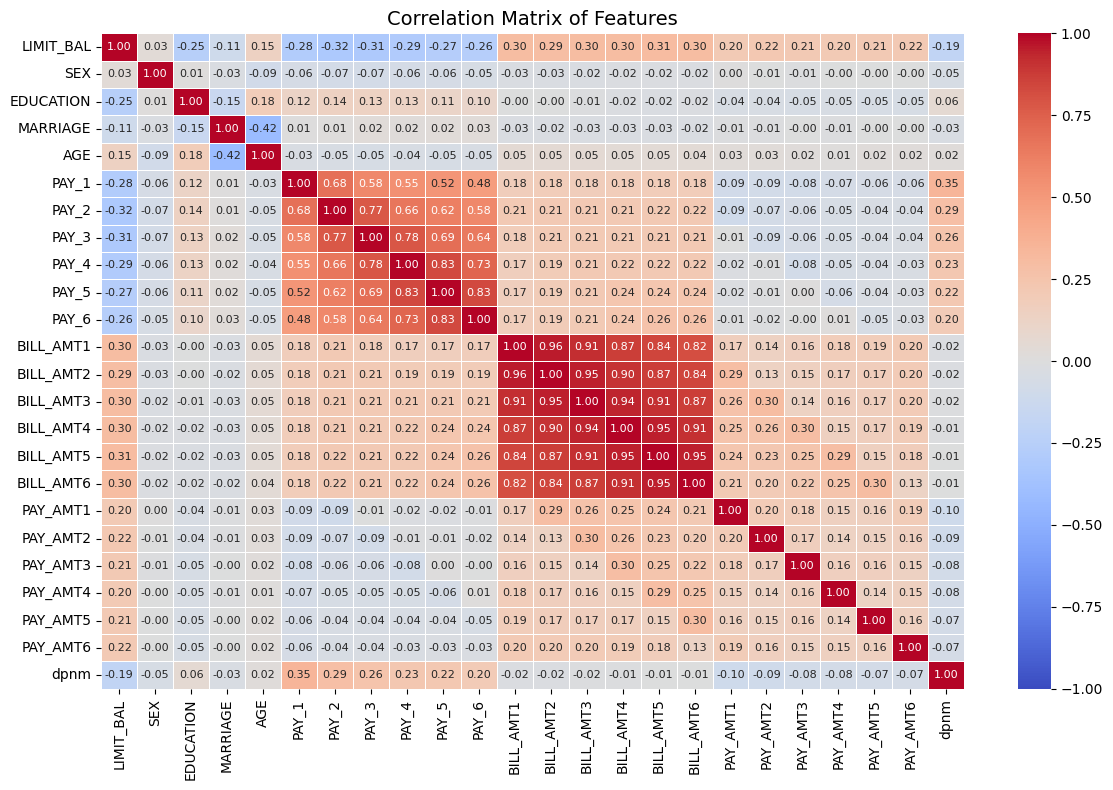

In [14]:
# Compute the correlation matrix 
correlation_matrix = df.corr()

plt.figure(figsize=(12, 8)) 
sns.heatmap(
    correlation_matrix,
    annot=True,                
    cmap='coolwarm',           
    fmt='.2f',                 
    cbar=True,                 
    linewidths=0.5,            
    annot_kws={"size": 8},     
    vmin=-1, vmax=1            
)

plt.title("Correlation Matrix of Features", fontsize=14)
plt.tight_layout()  
plt.show()

The BILL_AMT influence eachother as they build ontop of eachother like a hill. The PAY_ feature shows delinquency on the Bill. The reason PAY_1 has the greatest affect on dpnm is because that is the month directly before deciding the target class of "next month". If a client is delinquent last month it's a higher chance they will fall behind on the upcoming month. PAY_ also affect eachother as falling behind tends to cause more falling behind.

PAY_AMT has a positive correlation with BILL_AMT, and BILL_AMT has a positive correlation with PAY_, while pay has the only positive correlation with the target class dpnm. So in essences, PAY_AMT has a cascading affect on the rest of the data; Which is obvious but given we have no external data on the clients such as income, this would be the lowest point where information is generated from.

Age, sex and education can identify a demographic that does or doesn't pay, but its affect on the data is that the Limit_Bal is partially determined based on such factors (the lower educated offered less due to risk, Men and older people offered Higher LIMIT ceilings)

some interesting things to note is that as age goes up, the probability of marriage is significantly increased to "married". And a lower LIMIT__BAL increases the likelyhood of a class 1 label.

## Categorical Analysis

In [15]:
def plotRatio(feature,df):
    """
    Visualizes the relationship between a categorical feature and a target variable using a count plot.

    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        feature (str): The column name for the class label.

    Returns:
        None: Displays a plot showing the distribution of the specified feature grouped by the target variable 'dpnm'.
    """
    plt.figure(figsize=(3, 3)) 
    sns.countplot(x = feature, data = df, palette = 'rocket', hue = 'dpnm')
    plt.title(f'Distribution of {feature} by dpnm')
    plt.tight_layout()
    plt.show()

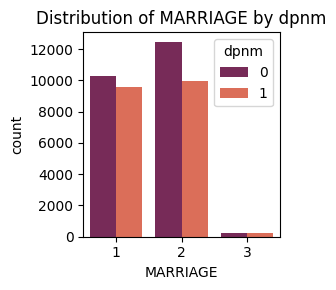

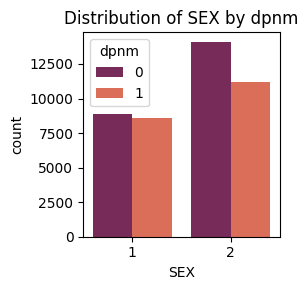

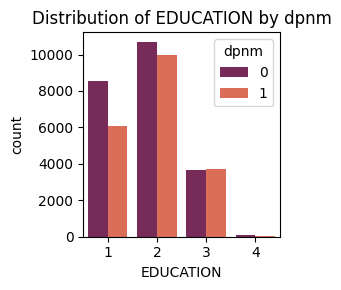

In [16]:
# View distribution of categorical features and their association to dpnm
features_to_plot = ['MARRIAGE', 'SEX', 'EDUCATION']

for feature in features_to_plot:
    plotRatio(feature,df)

Text(-9.374143518518506, 0.5, 'Count')

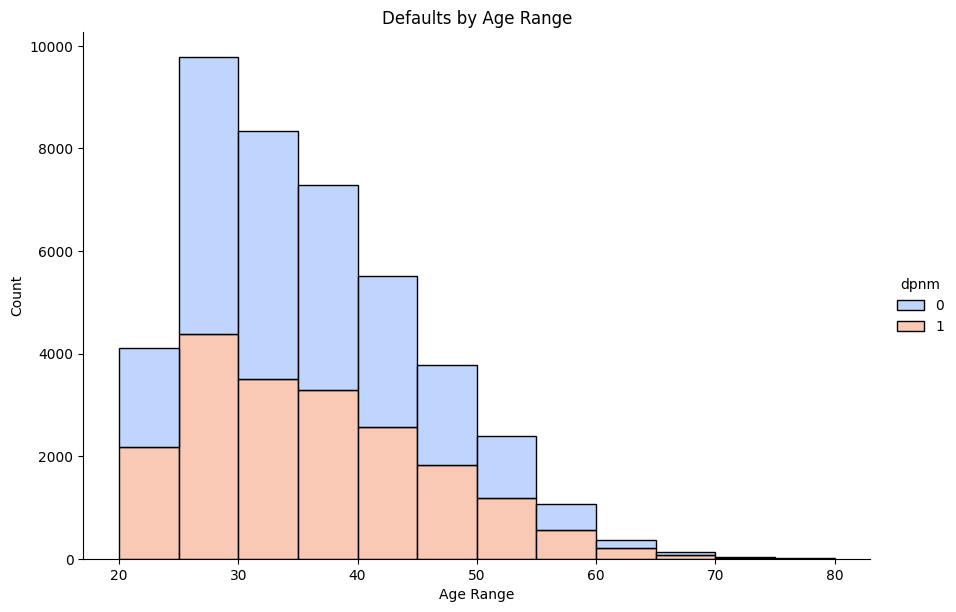

In [17]:
sns.displot(
    data=df,
    x='AGE',
    hue='dpnm', 
    kind='hist',
    bins=range(20, 81, 5), 
    multiple='stack',
    palette='coolwarm',
    height=6, aspect=1.5
)
plt.title('Defaults by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

So based on the categorical data, we can say the safest client is a single graduate educated female withiin the 25-45 age range, and the least safe client is a married college grad male within the 45-70 age bracket.

## Numerical Data Analysis

In [18]:
def trendPlotter(df):
    # This function was made with significant aid from chat-gpt
    """
    Analyzes trends in numerical values over a 6-month period and visualizes the relationship 
    between the features

    The trend is calculated by iterating backward in time, so we flip the graph to have it in chronilogical order
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
    Returns:
        None: Just prints the plot 
    """
    # Plot the trends of the dependant features (PAY_,PAY_AMT,BILL_AMT), this is a min-max normalization of the features
    pay_means = [(df[f"PAY_{i}"].mean() - df[f"PAY_{i}"].min()) /
                 (df[f"PAY_{i}"].max() - df[f"PAY_{i}"].min())
                 for i in range(1, 7)]
    
    bill_means = [(df[f"BILL_AMT{i}"].mean() - df[f"BILL_AMT{i}"].min()) /
                  (df[f"BILL_AMT{i}"].max() - df[f"BILL_AMT{i}"].min())
                  for i in range(1, 7)]
    
    pay_amt_means = [(df[f"PAY_AMT{i}"].mean() - df[f"PAY_AMT{i}"].min()) /
                     (df[f"PAY_AMT{i}"].max() - df[f"PAY_AMT{i}"].min())
                     for i in range(1, 7)]
    
    x_labels = [f"VAL_{i}" for i in range(1, 7)]
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, pay_means, label="PAY_", marker="o", linestyle="--")
    plt.plot(x_labels, bill_means, label="BILL_AMT", marker="s", linestyle="-.")
    plt.plot(x_labels, pay_amt_means, label="PAY_AMT", marker="d", linestyle="-")
    
    plt.xlabel("Metrics (VAL_1 to VAL_6)")
    plt.ylabel("Average Values")
    plt.title("Overall Average Values for PAY, BILL_AMT, and PAY_AMT")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.gca().invert_xaxis()
    plt.show()

Original DF


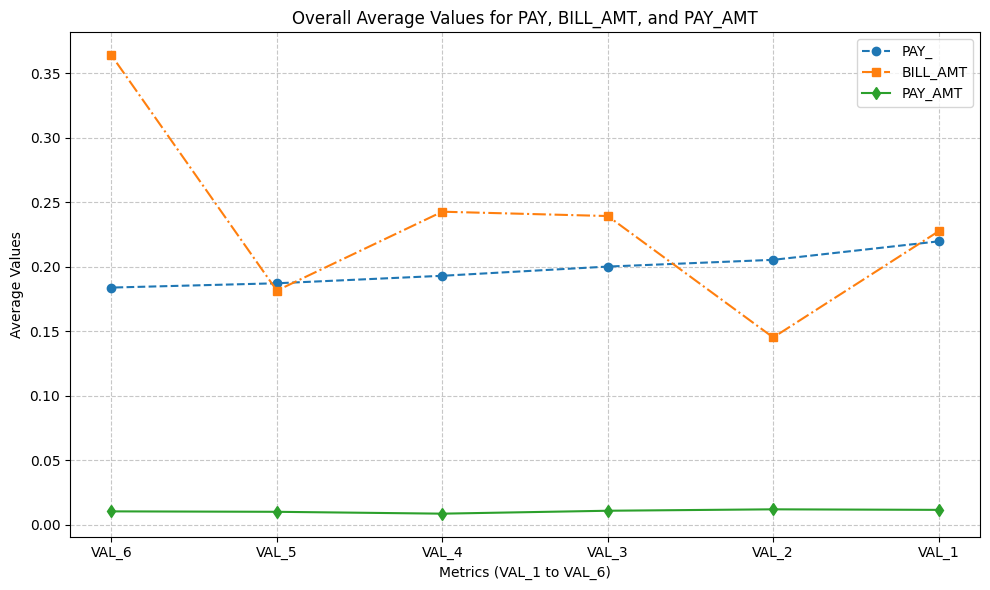

Pays next month DF


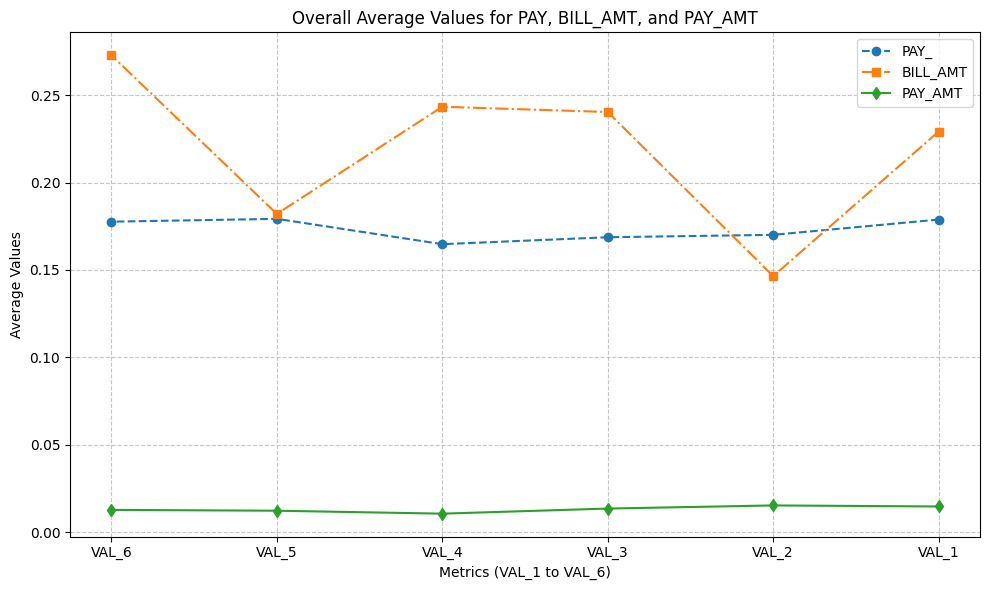

Does not pay next month DF


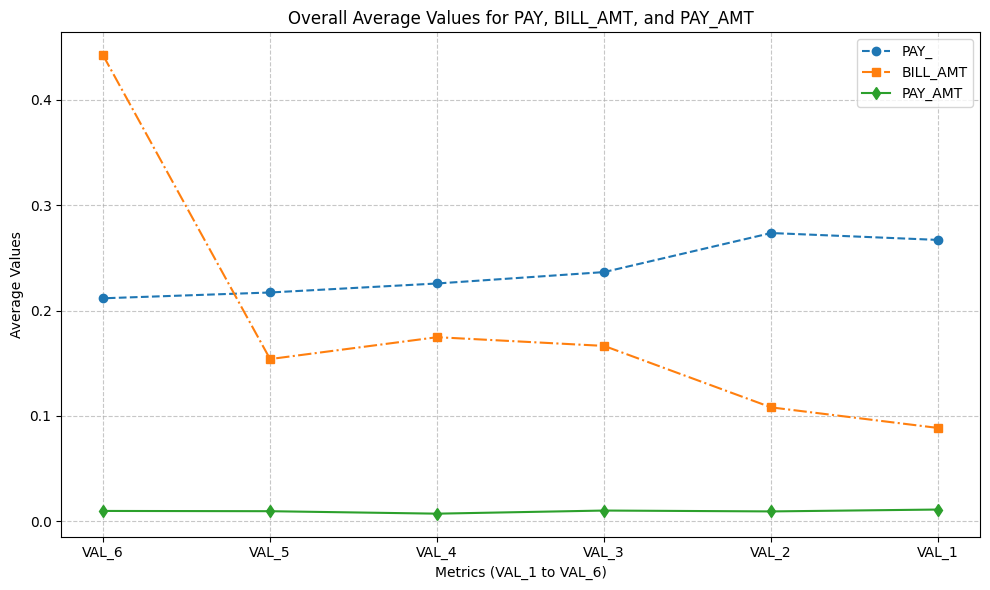

In [19]:
print("Original DF")
trendPlotter(df)
print("Pays next month DF")
trendPlotter(class_0_data)
print("Does not pay next month DF")
trendPlotter(class_1_data)

I flipped the graph so that it can be in chronological order. The scales of the graphs are not the same this is specifically to see general trends within those who pay and dont pay

There are most likely holidays and events that occur between the months of April to September which can explain why the starting BILL_AMT is so high along with some other behaviors.

ALL THE DETAILS WE HAVE LEARNED ABOUT THE DATA:

Our general pattern exists below PAY_ values of 3, above that are outliers

Factors that greater chances of leading to Class label 1: Lower LIMIT_BAL, lower PAY_AMT

Factors that have greater chances of leading to Class label 0: Lower PAY_, increasing BILL_AMT, larger PAY_AMT

## Split and Scale

In [20]:
# 70-30 split 
features = df.drop('dpnm', axis=1)
labels = df['dpnm']
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.3, random_state=RAND_SEED
)

In [24]:
scaler = StandardScaler()
scaler.fit(train_features)
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)
print("Normalized Train Features (first 5 rows):")
print(train_features[:1])

Normalized Train Features (first 5 rows):
[[ 1.45287588 -1.20102389 -1.18154691 -1.04989173 -0.16613306 -0.94727351
  -0.78965758 -0.75478719 -0.71173983  1.67752094  0.13171418 -0.67481382
  -0.67219344 -0.66691578  1.53753424  1.6264839   1.30094844 -0.33708275
  -0.29454708  9.75465031 -0.31226492  1.06350496 -0.09762978]]


In [25]:
# Normalize the data for the neural network layer
normalizer = tf.keras.layers.Normalization(axis=1) 
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy()) 

[[-3.4924597e-09 -3.7609425e-08 -4.6318746e-08  9.3496055e-09
  -1.1077645e-09  4.8537913e-08 -1.3100362e-08  2.2526365e-08
   8.8039087e-09  3.2694516e-08  1.9645086e-09 -1.7462298e-10
   1.0913936e-11 -1.5024852e-09 -3.2741809e-09  6.5265340e-09
  -2.8740033e-10 -3.1141099e-09 -3.3396645e-09 -1.3023964e-09
  -2.4629117e-09  1.1183147e-08 -2.4738256e-10]]


In [26]:
## Uncomment this to use a functional OverSampler duplication for class 1 label, this is gives worse results than doing it manually though?
#ros = RandomOverSampler(random_state=RAND_SEED)
#train_features,train_labels=ros.fit_resample(train_features,train_labels)

In [27]:
print(train_labels.value_counts())

dpnm
0    16089
1    13836
Name: count, dtype: int64


In [28]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first,'\n')
  print('Normalized:', normalizer(first).numpy())

First example: [[ 1.45 -1.2  -1.18 -1.05 -0.17 -0.95 -0.79 -0.75 -0.71  1.68  0.13 -0.67
  -0.67 -0.67  1.54  1.63  1.3  -0.34 -0.29  9.75 -0.31  1.06 -0.1 ]] 

Normalized: [[ 1.45 -1.2  -1.18 -1.05 -0.17 -0.95 -0.79 -0.75 -0.71  1.68  0.13 -0.67
  -0.67 -0.67  1.54  1.63  1.3  -0.34 -0.29  9.75 -0.31  1.06 -0.1 ]]


# Functions 

In [29]:
def build_and_compile_model12(norm):
    """
    Builds and compiles a sequential neural network model with a simpler architecture.
    
    Parameters:
        norm (tf.keras.layers.Layer): A normalization layer to preprocess the input data.
    
    Returns:
        tf.keras.Model: The compiled model with two hidden layers and a sigmoid output layer for binary classification.
    """
    model = tf.keras.models.Sequential([
      norm,
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation ='sigmoid')
    ])
    model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

In [30]:
def build_and_compile_model1(norm):
    """
    Builds and compiles a sequential neural network model with dropout for regularization.
    
    Parameters:
        norm (tf.keras.layers.Layer): A normalization layer to preprocess the input data.
    
    Returns:
        tf.keras.Model: The compiled model with two hidden layers, dropout layers, and a sigmoid output layer for binary classification.
    """
    model = tf.keras.models.Sequential([
      norm,
      tf.keras.layers.Dense(192, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(192, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
    return model

In [31]:
def plot_loss(history):
    """
    Plots the training and validation loss over epochs.
    
    Parameters:
        history (tf.keras.callbacks.History): The history object from a model's training process.
    
    Returns:
        None: Displays a line plot of loss vs. epochs.
    """
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [dpnm]')
    plt.legend()
    plt.grid(True)

In [32]:
def CM(model,tested_features,tested_labels):
    """
    Generates and displays a confusion matrix for the Neural Network model's predictions.

    Parameters:
        model (tf.keras.Model): The trained model.
        tested_features (np.array or pd.DataFrame): The features used for testing.
        tested_labels (np.array or pd.Series): The true labels for testing.

    Returns:
        None: Displays a confusion matrix plot.
    """
    test_predictions = model.predict(tested_features) 
    binary_predictions = (test_predictions > 0.6).astype(int) # Sigmoid probability output
    
    cm = confusion_matrix(tested_labels, binary_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

In [33]:
def plot_auc(model, X_test, y_test):
    """
    Plots the Receiver Operating Characteristic (ROC) curve and computes the AUC for the model.

    Parameters:
        model (tf.keras.Model): The trained model.
        X_test (np.array or pd.DataFrame): The features used for testing.
        y_test (np.array or pd.Series): The true labels for testing.

    Returns:
        None: Displays the ROC curve and AUC value.
    """
    y_prob = model.predict(X_test)
    
    # If the model outputs probabilities for each class, take the probability for the positive class
    if y_prob.shape[1] == 2  :
        y_prob = y_prob[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Logistic Regression

In [34]:
log_reg=LogisticRegression(random_state=RAND_SEED)
log_reg.fit(train_features,train_labels)

LogisticRegression(random_state=42)

In [35]:
log_pred=log_reg.predict(test_features)
log_reg_cross_val=cross_val_score(log_reg,train_features, train_labels, cv=5).mean()

In [36]:
print(classification_report(test_labels, log_pred))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      6867
           1       0.71      0.56      0.63      5958

    accuracy                           0.69     12825
   macro avg       0.70      0.68      0.68     12825
weighted avg       0.70      0.69      0.69     12825



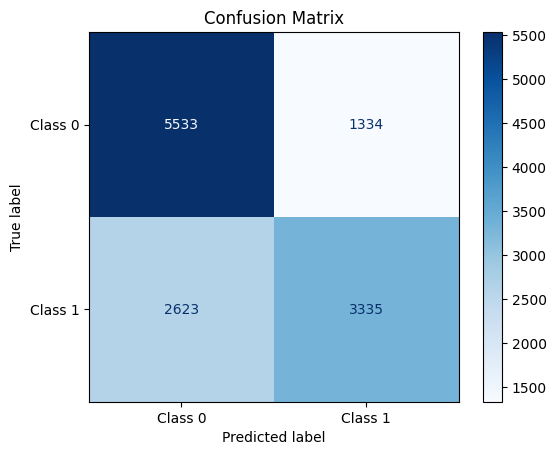

In [37]:
CM(log_reg,test_features,test_labels) 

## Grid Search Logistic Regression

In [38]:
parameters = {'C':[0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000], 
              'solver':['lbfgs','sag','saga','newton-cg']}
base_log_reg=LogisticRegression(random_state=RAND_SEED)
gs_log_reg=GridSearchCV(base_log_reg, parameters, cv=10, n_jobs=-1, verbose=1)
gs_log_reg.fit(train_features,train_labels)

Fitting 10 folds for each of 32 candidates, totalling 320 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 1, 0.1, 10, 100, 1000],
                         'solver': ['lbfgs', 'sag', 'saga', 'newton-cg']},
             verbose=1)

In [39]:
gs_log_pred=gs_log_reg.predict(test_features)
print(classification_report(test_labels, gs_log_pred))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      6867
           1       0.71      0.56      0.62      5958

    accuracy                           0.69     12825
   macro avg       0.70      0.68      0.68     12825
weighted avg       0.69      0.69      0.68     12825



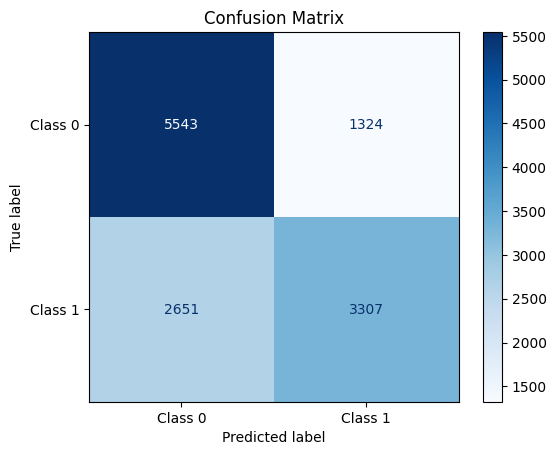

In [40]:
CM(gs_log_reg,test_features,test_labels) 

# Decision Tree

In [41]:
dt_model = DecisionTreeClassifier(criterion='gini',random_state=RAND_SEED)
dt_model.fit(train_features,train_labels)
dt_model_pred = dt_model.predict(test_features)

In [42]:
dt_model_cv=cross_val_score(dt_model,train_features,train_labels,cv=10).mean()

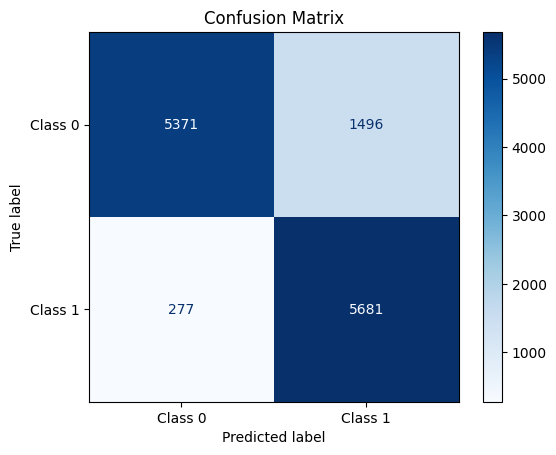

In [43]:
CM(dt_model,test_features,test_labels) 

## Grid Search Decision Tree 

In [44]:
parameters = {'criterion':['gini','entropy'],
              'max_depth':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30]
             }
default_tr = DecisionTreeClassifier(random_state=RAND_SEED)
gs_dt_model = GridSearchCV(default_tr, parameters, cv=10, n_jobs=-1,verbose=1)
gs_dt_model.fit(train_features,train_labels)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22,
                                       24, 26, 28, 30]},
             verbose=1)

In [45]:
gs_dt_model_pred=gs_dt_model.predict(test_features)

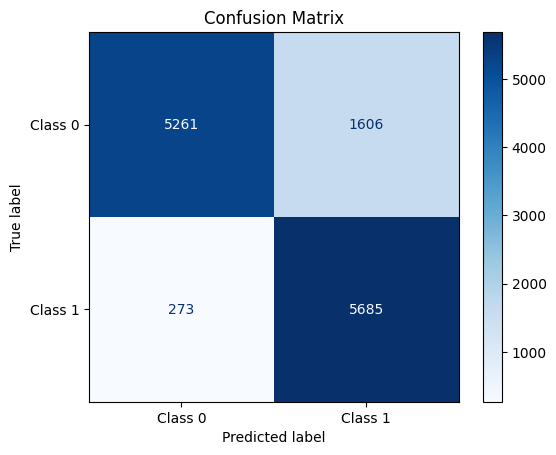

In [46]:
CM(gs_dt_model,test_features,test_labels) 

# Neural Networks

## Neural Network Model_1

In [47]:
# Make both classes equivalent on weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.9299832183479396, 1: 1.0814180398959237}


In [48]:
dnn_model = build_and_compile_model1(normalizer)
dnn_model.summary()

history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.3,
    batch_size=BATCH_SIZE,
    verbose=1, 
    epochs=300,
    class_weight=class_weights_dict
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 23)               47        
 n)                                                              
                                                                 
 dense (Dense)               (None, 192)               4608      
                                                                 
 dropout (Dropout)           (None, 192)               0         
                                                                 
 dense_1 (Dense)             (None, 192)               37056     
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 193       
                                                        

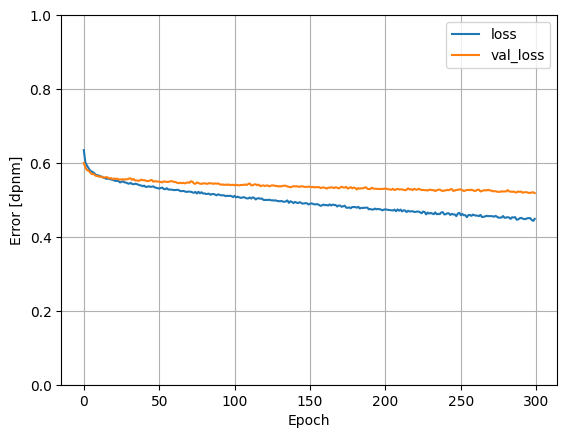

In [49]:
plot_loss(history)

In [50]:
test_results= { }
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=2)
# so here we are getting my ACTUAL accuracy and can see better metrics
# This is overfitting but in our case overfitting is relatively alright given the type of data being input.

401/401 - 2s - loss: 0.5278 - accuracy: 0.7450 - auc: 0.8212 - precision: 0.7138 - recall: 0.7528 - 2s/epoch - 5ms/step


401/401 [==============================] - 1s 2ms/step


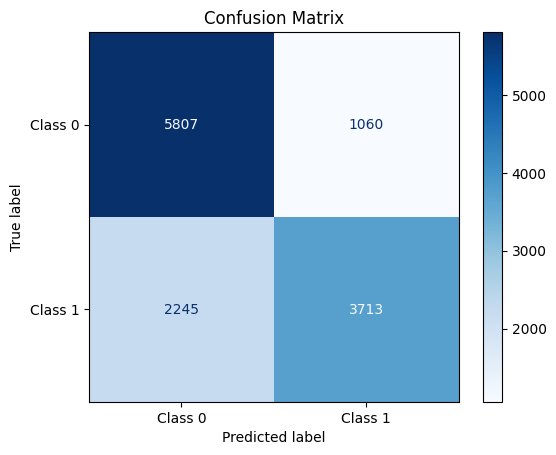

In [51]:
CM(dnn_model,test_features,test_labels)

401/401 [==============================] - 1s 2ms/step


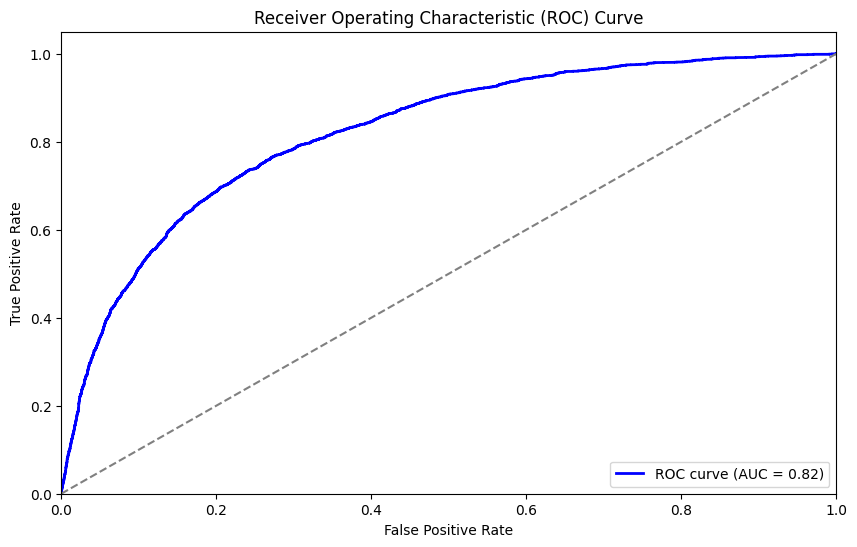

In [52]:
plot_auc(dnn_model,test_features,test_labels)

## Neural Network Model_2

In [69]:
dnn_model2 = build_and_compile_model12(normalizer)
dnn_model2.summary()

history = dnn_model2.fit(
    train_features,
    train_labels,
    validation_split=0.3,
    verbose=0, 
    epochs=50,
    batch_size=BATCH_SIZE
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 23)               47        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 32)                768       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                      

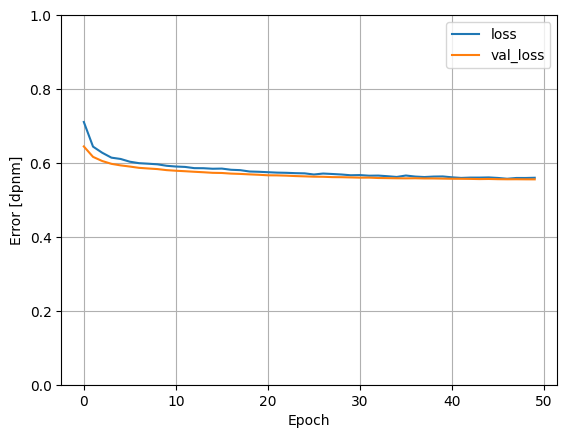

In [70]:
plot_loss(history)

401/401 [==============================] - 1s 2ms/step


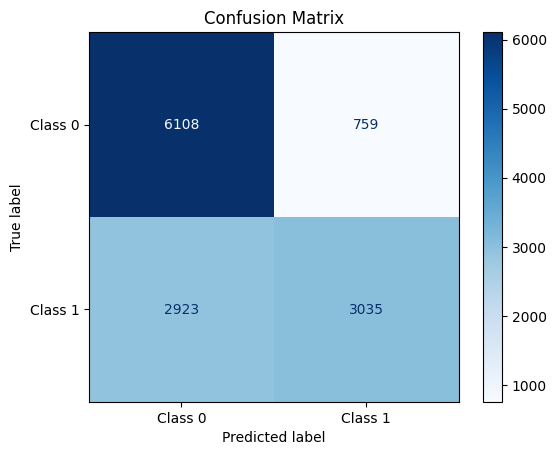

In [71]:
CM(dnn_model2,test_features,test_labels)

401/401 [==============================] - 1s 2ms/step


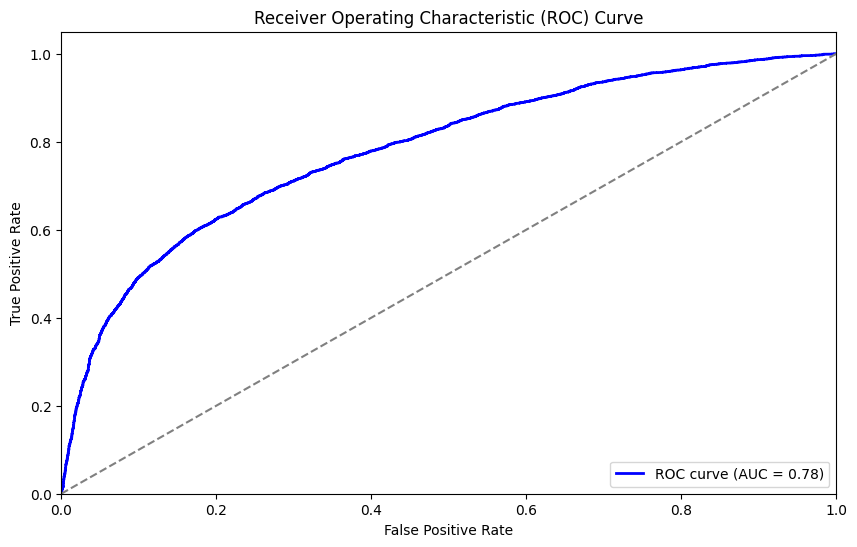

In [72]:
plot_auc(dnn_model2,test_features,test_labels)

## HyperParameter Tuning NN Model 1

In [73]:
# Removing the tuner dir until i'm content with my results
#tuner_dir = './untitled_project'
#shutil.rmtree(tuner_dir)


Reloading Tuner from .\untitled_project\tuner0.json
401/401 [==============================] - 2s 5ms/step - loss: 0.5473 - accuracy: 0.7235 - auc: 0.7939 - precision: 0.7452 - recall: 0.6151
Test Loss: 0.5472863912582397
Test Accuracy: 0.7235087752342224
Test AUC: 0.7939399480819702
Test Precision: 0.7452216148376465
Test Recall: 0.6151393055915833
401/401 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      6867
           1       0.75      0.62      0.67      5958

    accuracy                           0.72     12825
   macro avg       0.73      0.72      0.72     12825
weighted avg       0.73      0.72      0.72     12825



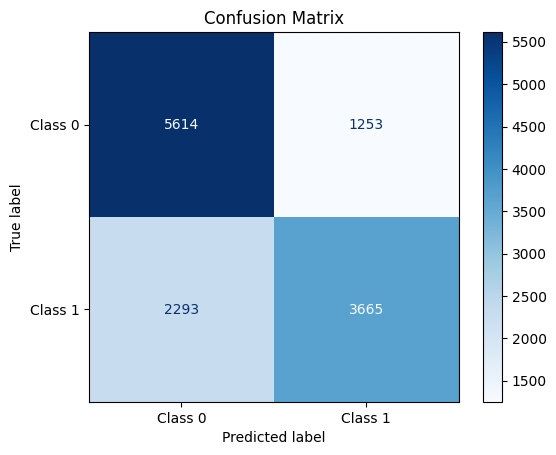

In [74]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Updated NN model with hidden layers able to change size
def build_model(hp):
    
    normalization_layer = tf.keras.layers.Normalization(axis=-1)
    normalization_layer.adapt(train_features)
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(train_features.shape[1],)),
        tf.keras.layers.Dense(hp.Int('units1', min_value=32, max_value=128, step=32), activation='relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout1', 0.2, 0.4, step=0.1)),
        tf.keras.layers.Dense(hp.Int('units2', min_value=32, max_value=128, step=32), activation='relu'),
        tf.keras.layers.Dropout(rate=hp.Float('dropout2', 0.2, 0.4, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Use the learning rate schedule for the optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC', 'Precision', 'Recall']
    )
    return model
    
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Set up Keras Tuner for hyperparameter optimization
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective('val_loss',direction='min'),
    max_epochs=100,
    hyperband_iterations=5,
    seed=RAND_SEED
)

# Perform the search for the best hyperparameters
tuner.search(train_features, train_labels, validation_split=0.3, epochs=10,callbacks=[early_stopping],batch_size=BATCH_SIZE)

# Get the best model after hyperparameter tuning
best_model = tuner.get_best_models(1)[0]

# Train the best model with dynamic class weights
history = best_model.fit(
    train_features,
    train_labels,
    validation_split=0.3,
    batch_size=BATCH_SIZE,
    epochs=10,
    verbose=0
)

# Evaluate the model on the test data
test_loss, test_accuracy, test_auc, test_precision, test_recall = best_model.evaluate(test_features, test_labels, verbose=1)

# Print the evaluation metrics
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

y_pred = best_model.predict(test_features)
y_pred = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(test_labels, y_pred))

# Plot confusion matrix
cm = confusion_matrix(test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## I left it as a giant block to provide insight into how i got more efficient with the next model

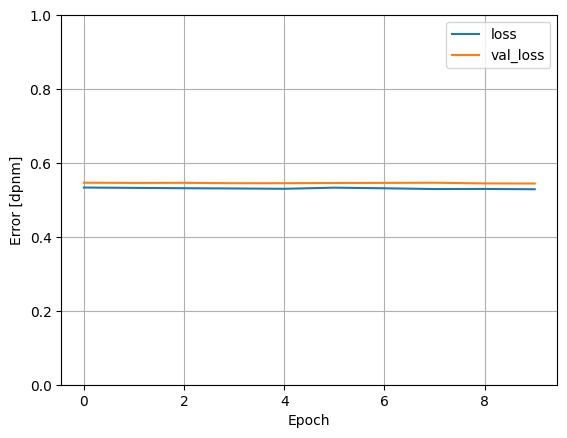

In [75]:
plot_loss(history)

401/401 [==============================] - 1s 1ms/step


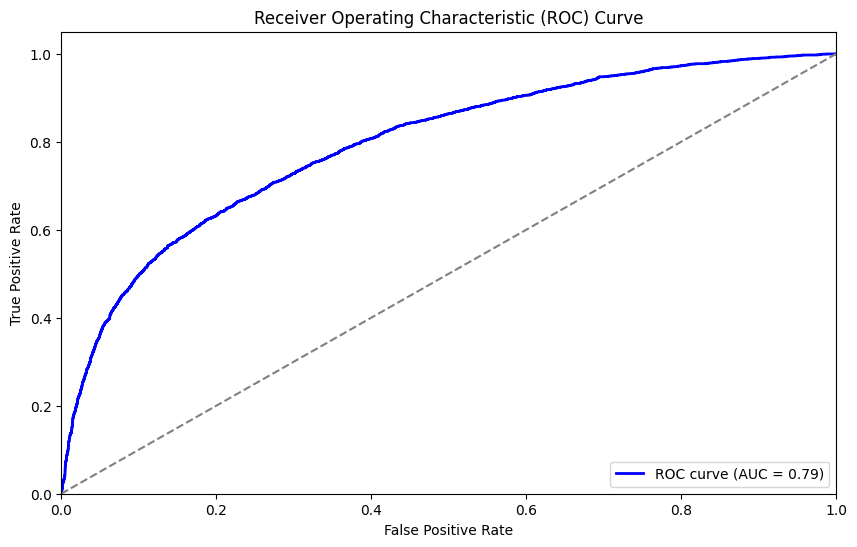

In [76]:
plot_auc(best_model,test_features,test_labels)

## Hyper parameter tuning Version 2

In [77]:
def model_builder(hp):
    model = tf.keras.Sequential()
    tf.keras.layers.InputLayer(input_shape=(train_features.shape[1],)),
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model


In [78]:
#tuner_dir = 'my_dir/NN_test'
#shutil.rmtree(tuner_dir, ignore_errors=True)

In [79]:
    tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory='my_dir',
                     project_name='NN_test')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    tuner.search(train_features, train_labels, epochs=50, validation_split=0.3, callbacks=[stop_early],batch_size=BATCH_SIZE)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    
    print(f"""
    The hyperparameter search is complete. The optimal number of units {best_hps.get('units')} and the optimal learning rate for the optimizer
    is {best_hps.get('learning_rate')}.
    """)
    

Reloading Tuner from my_dir\NN_test\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal learning rate for the optimizer
is 0.01.



In [80]:
    # Build the model with the optimal hyperparameters and train it on the data for 50 epochs
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_features, train_labels, epochs=50, validation_split=0.2)
    
    val_acc_per_epoch = history.history['val_accuracy']
    best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,))
# this is to find the best runtime for the best parameters, could have possibly done this in the previous step.

Epoch 1/50
749/749 [==============================] - 4s 5ms/step - loss: 0.5943 - accuracy: 0.7028 - val_loss: 0.5719 - val_accuracy: 0.7106
Epoch 2/50
749/749 [==============================] - 3s 4ms/step - loss: 0.5764 - accuracy: 0.7117 - val_loss: 0.5815 - val_accuracy: 0.7023
Epoch 3/50
749/749 [==============================] - 4s 5ms/step - loss: 0.5684 - accuracy: 0.7119 - val_loss: 0.5627 - val_accuracy: 0.7118
Epoch 4/50
749/749 [==============================] - 3s 4ms/step - loss: 0.5633 - accuracy: 0.7169 - val_loss: 0.5655 - val_accuracy: 0.7103
Epoch 5/50
749/749 [==============================] - 3s 4ms/step - loss: 0.5624 - accuracy: 0.7172 - val_loss: 0.5597 - val_accuracy: 0.7168
Epoch 6/50
749/749 [==============================] - 3s 4ms/step - loss: 0.5594 - accuracy: 0.7188 - val_loss: 0.5589 - val_accuracy: 0.7128
Epoch 7/50
749/749 [==============================] - 3s 4ms/step - loss: 0.5580 - accuracy: 0.7144 - val_loss: 0.5598 - val_accuracy: 0.7099
Epoch 

In [81]:
    hypermodel = tuner.hypermodel.build(best_hps)
    # Retrain the model
    hypermodel.fit(train_features, train_labels, epochs=best_epoch, validation_split=0.2)

Epoch 1/23
749/749 [==============================] - 4s 5ms/step - loss: 0.5920 - accuracy: 0.7021 - val_loss: 0.5718 - val_accuracy: 0.7118
Epoch 2/23
749/749 [==============================] - 3s 4ms/step - loss: 0.5727 - accuracy: 0.7137 - val_loss: 0.5792 - val_accuracy: 0.7133
Epoch 3/23
749/749 [==============================] - 3s 5ms/step - loss: 0.5675 - accuracy: 0.7156 - val_loss: 0.5810 - val_accuracy: 0.7088
Epoch 4/23
749/749 [==============================] - 3s 5ms/step - loss: 0.5629 - accuracy: 0.7175 - val_loss: 0.5728 - val_accuracy: 0.7160
Epoch 5/23
749/749 [==============================] - 3s 4ms/step - loss: 0.5607 - accuracy: 0.7180 - val_loss: 0.5579 - val_accuracy: 0.7178
Epoch 6/23
749/749 [==============================] - 3s 5ms/step - loss: 0.5572 - accuracy: 0.7185 - val_loss: 0.5751 - val_accuracy: 0.7160
Epoch 7/23
749/749 [==============================] - 4s 5ms/step - loss: 0.5546 - accuracy: 0.7212 - val_loss: 0.5585 - val_accuracy: 0.7128
Epoch 

In [82]:
eval_result = hypermodel.evaluate(test_features, test_labels)
print("[test loss, test accuracy]:", eval_result)

401/401 [==============================] - 1s 2ms/step - loss: 0.5602 - accuracy: 0.7182
[test loss, test accuracy]: [0.5602412819862366, 0.7182066440582275]


401/401 [==============================] - 1s 1ms/step


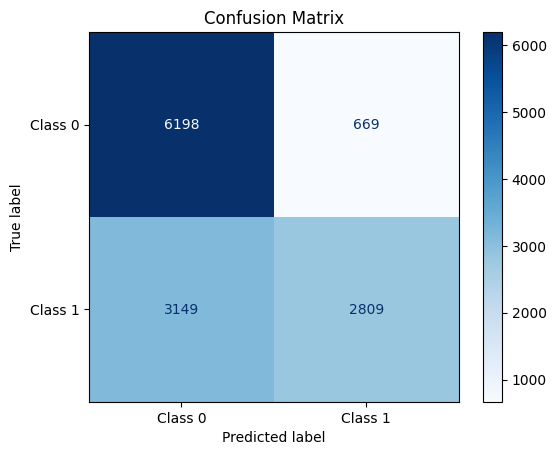

In [83]:
CM(hypermodel,test_features,test_labels)

401/401 [==============================] - 0s 1ms/step


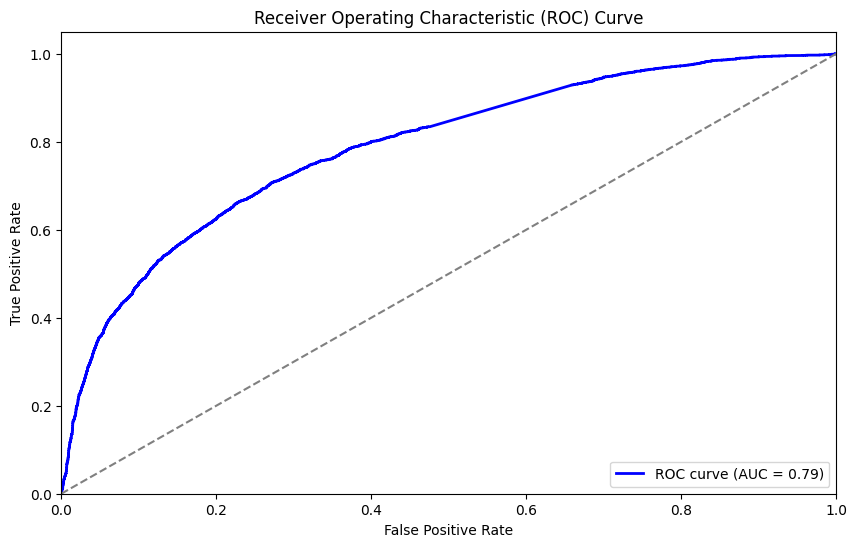

In [84]:
plot_auc(hypermodel,test_features,test_labels)